# Pipeline Modelling

In [1]:
import pandas as pd
import numpy as np

In [2]:
diabetes = pd.read_csv('cleaned_diabetes.csv')
diabetes = diabetes.drop(columns={'Unnamed: 0'})
diabetes.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,...,change_yes,change_no,diabetesMed_yes,diabetesMed_no,age_encoding,glu_serum_encoding,A1C_encoded,total_visits,polypharmacy,num_meds_chanaged
0,1,41,0,1,0,0,0,1,No,No,...,0,1,0,1,0,0,0,0,0,0
1,3,59,0,18,0,0,0,9,No,No,...,1,0,1,0,1,0,0,0,1,1
2,2,11,5,13,2,0,1,6,No,No,...,0,1,1,0,2,0,0,3,1,0
3,2,44,1,16,0,0,0,7,No,No,...,1,0,1,0,3,0,0,0,1,1
4,1,51,0,8,0,0,0,5,No,No,...,1,0,1,0,4,0,0,0,1,0


In [3]:
X = diabetes.drop(columns=['readmitted'])
y = diabetes['readmitted'] # what we're predicting

In [4]:
diabetes['readmitted'].value_counts(normalize=True)

readmitted
0    0.888424
1    0.111576
Name: proportion, dtype: float64

Since only 11.16% of the data is labelled as readmitted within 30 days, this is a **class imbalance**. We will need to account for it to avoid the mostly being biased and select the majority class, No or > 30, every time. 

In [5]:
diabetes['tolazamide'].unique()

array(['No', 'Steady', 'Up'], dtype=object)

In [6]:
# 80% train, 10% validation, 10% test
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [7]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

In [8]:
# We also need to encode the medication! 
meds = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone'
]

med_encoding = {'No':0,'Down':1,'Steady':2,'Up':3}
for col in meds:
    if col in X_train.columns:
        X_train[col] = X_train[col].map(med_encoding)
        X_val[col] = X_val[col].map(med_encoding)
        X_test[col] = X_test[col].map(med_encoding)


In [9]:
meds = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone'
]
for col in meds:
    print(X_train[col].unique())

[0 2 1 3]
[0 2 3 1]
[0 2 3 1]
[0 2 3]
[0 2 3 1]
[0 2]
[0 2 3 1]
[0 2 3 1]
[0 2]
[1 0 2 3]
[0 1 2 3]
[0 2 3 1]
[0 2 1 3]
[0]
[0 2 3]
[0 1 2 3]
[0 2 3 1]
[0 2]
[0]


## Logistic Regression Model

In [10]:
# Logistic Regression Model
num_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses', 'age_encoding',
    'glu_serum_encoding', 'A1C_encoded', 'total_visits'
]

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [11]:
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [12]:
# Predict on validation set
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]

print("Validation Set Evaluation:")
print(classification_report(y_val, y_val_pred))
print("ROC AUC:", roc_auc_score(y_val, y_val_prob))


Validation Set Evaluation:
              precision    recall  f1-score   support

           0       0.92      0.69      0.79      9039
           1       0.18      0.55      0.27      1135

    accuracy                           0.67     10174
   macro avg       0.55      0.62      0.53     10174
weighted avg       0.84      0.67      0.73     10174

ROC AUC: 0.674763153110871


## Random Forest Model

In [13]:
# improve with random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced', 
    random_state=42
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [14]:
# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val)
y_val_prob_rf = rf_model.predict_proba(X_val)[:, 1]

print("Validation Set Evaluation:")
print(classification_report(y_val, y_val_pred_rf))
print("ROC AUC:", roc_auc_score(y_val, y_val_prob_rf))


Validation Set Evaluation:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      9039
           1       0.57      0.01      0.02      1135

    accuracy                           0.89     10174
   macro avg       0.73      0.50      0.48     10174
weighted avg       0.85      0.89      0.84     10174

ROC AUC: 0.6530299197847019


In [15]:
y_val_pred_lr = model.predict(X_val)

print("Logistic Regression Accuracy:", accuracy_score(y_val, y_val_pred_lr))
print("Random Forest Accuracy:", accuracy_score(y_val, y_val_pred_rf))


Logistic Regression Accuracy: 0.6723019461372125
Random Forest Accuracy: 0.8887359937094554


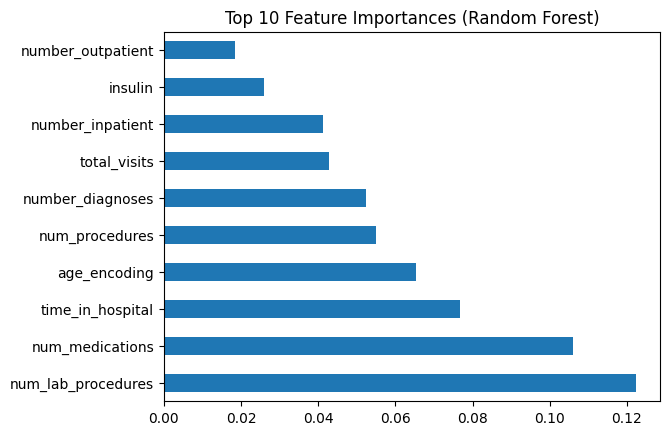

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()


## XGBoost Model


In [18]:
from xgboost import XGBClassifier

In [47]:
xgb_model = XGBClassifier(
    n_estimators = 100,
    max_depth = 5,
    learning_rate = 0.1,
    scale_pos_weight = 1,
    use_label_encoder = False,
    eval_metric = 'logloss',
    random_state = 42
)

In [48]:
xgb_model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:17:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [49]:
from sklearn.metrics import accuracy_score, classification_report

y_val_pred_xgb = xgb_model.predict(X_val)

print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))
print("Classification Report:\n", classification_report(y_val, y_val_pred_xgb))


XGBoost Validation Accuracy: 0.8884411244348339
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      9039
           1       0.50      0.00      0.01      1135

    accuracy                           0.89     10174
   macro avg       0.69      0.50      0.47     10174
weighted avg       0.85      0.89      0.84     10174



* Overall accuracy is ~88.9%, but this is dominated by the majority class (negatives) --> underestimating minority class

* The model is almost never correctly identifying the positive class (readmissions).

* This is confirmed by recall = 0.00 for class 1, meaning it missed almost all actual positives.

* Macro average recall and F1 are low due to poor positive class detection.

* This is a classic problem with imbalanced datasets — accuracy alone is misleading.

## Light GBM

In [35]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)

In [36]:
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9082, number of negative: 72311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 81393, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

In [37]:
y_val_pred_lgb = lgb_model.predict(X_val)

In [38]:
print("LGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_lgb))
print("Classification Report:\n", classification_report(y_val, y_val_pred_lgb))

LGBoost Validation Accuracy: 0.6590328287792412
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.67      0.78      9039
           1       0.19      0.61      0.28      1135

    accuracy                           0.66     10174
   macro avg       0.56      0.64      0.53     10174
weighted avg       0.85      0.66      0.72     10174



## Fine-tune with Hyperparameters

In [58]:
# we will use the XGBoost Model
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'max_depth': [3,5,7,9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 7]
}

random_search = RandomizedSearchCV(
    estimator = XGBClassifier(
        n_estimators = 100,
        max_depth = 5,
        learning_rate = 0.1,
        scale_pos_weight = 1,
        eval_metric = 'logloss',
        random_state = 42
        ),
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=300, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=300, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=300, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=7, n_estimators=400, subsample=0.8; total t

In [ ]:
# scale scale_pos_weight to pay more attention to the minority class 
xgb_model = XGBClassifier(
    subsample= 0.8,
    n_estimators = 400,
    min_child_weight = 5,
    max_depth = 7,
    learning_rate = 0.01,
    colsample_bytree = 0.6,
    scale_pos_weight = np.sum(y_train==0) / np.sum(y_train==1),
    use_label_encoder = False,
    eval_metric = 'logloss',
    random_state = 42
)

In [66]:
xgb_model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:38:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

In [67]:
y_val_pred_xgb = xgb_model.predict(X_val)

print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))
print("Classification Report:\n", classification_report(y_val, y_val_pred_xgb))

XGBoost Validation Accuracy: 0.657951641438962
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.67      0.78      9039
           1       0.18      0.59      0.28      1135

    accuracy                           0.66     10174
   macro avg       0.55      0.63      0.53     10174
weighted avg       0.84      0.66      0.72     10174



In [69]:
for spw in [1, 2, 3, 5]:
    xgb_model = XGBClassifier(
        subsample= 0.8,
        n_estimators = 400,
        min_child_weight = 5,
        max_depth = 7,
        learning_rate = 0.01,
        colsample_bytree = 0.6,
        scale_pos_weight = np.sum(y_train==0) / np.sum(y_train==1),
        use_label_encoder = False,
        eval_metric = 'logloss',
        random_state = 42
    )
    xgb_model.fit(X_train, y_train)
    preds = xgb_model.predict(X_val)
    print(f"scale_pos_weight: {spw}")
    print(classification_report(y_val, preds))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:39:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


scale_pos_weight: 1
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      9039
           1       0.18      0.59      0.28      1135

    accuracy                           0.66     10174
   macro avg       0.55      0.63      0.53     10174
weighted avg       0.84      0.66      0.72     10174



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:39:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


scale_pos_weight: 2
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      9039
           1       0.18      0.59      0.28      1135

    accuracy                           0.66     10174
   macro avg       0.55      0.63      0.53     10174
weighted avg       0.84      0.66      0.72     10174



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:39:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


scale_pos_weight: 3
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      9039
           1       0.18      0.59      0.28      1135

    accuracy                           0.66     10174
   macro avg       0.55      0.63      0.53     10174
weighted avg       0.84      0.66      0.72     10174



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:39:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


scale_pos_weight: 5
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      9039
           1       0.18      0.59      0.28      1135

    accuracy                           0.66     10174
   macro avg       0.55      0.63      0.53     10174
weighted avg       0.84      0.66      0.72     10174



In [70]:
from sklearn.metrics import classification_report

y_proba = xgb_model.predict_proba(X_val)[:, 1]

for thresh in [0.3, 0.4, 0.5]:
    y_pred = (y_proba >= thresh).astype(int)
    print(f"\nThreshold: {thresh}")
    print(classification_report(y_val, y_pred))



Threshold: 0.3
              precision    recall  f1-score   support

           0       0.96      0.11      0.19      9039
           1       0.12      0.97      0.21      1135

    accuracy                           0.20     10174
   macro avg       0.54      0.54      0.20     10174
weighted avg       0.87      0.20      0.19     10174


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.95      0.38      0.54      9039
           1       0.14      0.83      0.24      1135

    accuracy                           0.43     10174
   macro avg       0.54      0.60      0.39     10174
weighted avg       0.86      0.43      0.51     10174


Threshold: 0.5
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      9039
           1       0.18      0.59      0.28      1135

    accuracy                           0.66     10174
   macro avg       0.55      0.63      0.53     10174
weighted avg       0.84   

In [71]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [5, 6, 7],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [2, 3, 5],
    'learning_rate': [0.01, 0.05],
}

grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                    param_grid, 
                    scoring='f1',
                    cv=3,
                    verbose=1)

grid.fit(X_train, y_train)
print(grid.best_params_)


Fitting 3 folds for each of 54 candidates, totalling 162 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:35:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:35:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:35:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:35:12] WARN

{'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'scale_pos_weight': 5}


In [143]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'scale_pos_weight': [4, 5, 6, 7],
    'max_depth': [4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(
    XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        colsample_bytree=0.6,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    param_grid,
    cv=3,
    scoring='f1',  # Optimize for F1-score
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best CV F1-score:", grid_search.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:42:26] WARN

Best parameters: {'max_depth': 4, 'min_child_weight': 3, 'scale_pos_weight': 7, 'subsample': 0.9}
Best CV F1-score: 0.27878902515928466


In [142]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

y_proba = xgb_model.predict_proba(X_val)[:, 1]

print("Threshold optimization:")
print("Thresh | Precision | Recall | F1-Score")
print("-" * 40)

best_f1 = 0
best_thresh = 0.44

for thresh in np.arange(0.35, 0.55, 0.01):
    y_pred = (y_proba >= thresh).astype(int)
    precision_1 = precision_score(y_val, y_pred)
    recall_1 = recall_score(y_val, y_pred)
    f1_1 = f1_score(y_val, y_pred)
    
    print(f"{thresh:.2f}   | {precision_1:.3f}     | {recall_1:.3f}  | {f1_1:.3f}")
    
    if f1_1 > best_f1:
        best_f1 = f1_1
        best_thresh = thresh

print(f"\nBest threshold: {best_thresh:.2f} with F1-score: {best_f1:.3f}")

Threshold optimization:
Thresh | Precision | Recall | F1-Score
----------------------------------------
0.35   | 0.133     | 0.878  | 0.232
0.36   | 0.136     | 0.865  | 0.235
0.37   | 0.138     | 0.846  | 0.238
0.38   | 0.140     | 0.828  | 0.240
0.39   | 0.143     | 0.807  | 0.243
0.40   | 0.145     | 0.788  | 0.245
0.41   | 0.148     | 0.765  | 0.248
0.42   | 0.152     | 0.747  | 0.253
0.43   | 0.155     | 0.727  | 0.256
0.44   | 0.158     | 0.704  | 0.258
0.45   | 0.160     | 0.675  | 0.259
0.46   | 0.164     | 0.655  | 0.262
0.47   | 0.167     | 0.633  | 0.265
0.48   | 0.171     | 0.614  | 0.268
0.49   | 0.177     | 0.598  | 0.273
0.50   | 0.180     | 0.573  | 0.274
0.51   | 0.186     | 0.555  | 0.279
0.52   | 0.191     | 0.532  | 0.281
0.53   | 0.197     | 0.508  | 0.284
0.54   | 0.202     | 0.480  | 0.284
0.55   | 0.207     | 0.454  | 0.285

Best threshold: 0.55 with F1-score: 0.285


Best threshold: 0.43, F1: 0.295


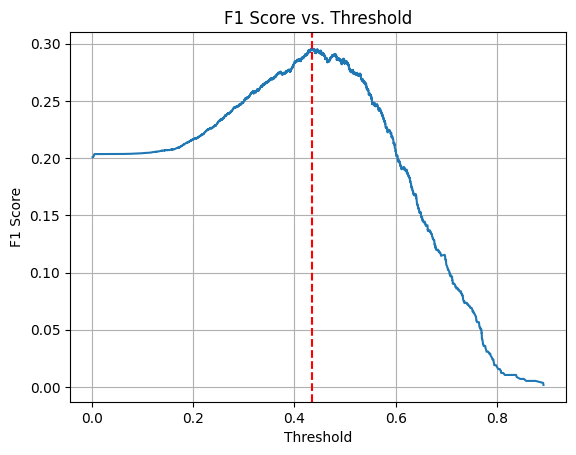

In [80]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

prec, rec, threshs = precision_recall_curve(y_val, y_proba)
f1 = 2 * prec * rec / (prec + rec + 1e-8)

best_idx = np.argmax(f1)
print(f"Best threshold: {threshs[best_idx]:.2f}, F1: {f1[best_idx]:.3f}")

plt.plot(threshs, f1[:-1])
plt.axvline(threshs[best_idx], color='r', linestyle='--')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.grid(True)
plt.show()


In [83]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

param_dist = {
    'n_estimators': randint(100, 600),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.1),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.5, 0.5),
    'scale_pos_weight': [5],  # fixed or slightly varied if needed
}

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    scoring='f1',
    n_iter=50,
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Best Params:", random_search.best_params_)



Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:46:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:46:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:46:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:46:22] WARN

Best Params: {'colsample_bytree': np.float64(0.8093574700581173), 'learning_rate': np.float64(0.037281761570859454), 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 527, 'scale_pos_weight': 5, 'subsample': np.float64(0.7956447755377811)}


In [104]:
xgb_model = XGBClassifier(
    subsample= 0.7956447755377811,
    n_estimators = 527,
    min_child_weight = 2,
    max_depth = 3,
    learning_rate = 0.037281761570859454,
    colsample_bytree = 0.8093574700581173,
    scale_pos_weight = 5,
    use_label_encoder = False,
    eval_metric = 'logloss',
    random_state = 42
)
xgb_model.fit(X_train, y_train)
y_val_pred_xgb = xgb_model.predict(X_val)

print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))

y_proba = xgb_model.predict_proba(X_val)[:, 1]
thresh = 0.44
y_pred = (y_proba >= thresh).astype(int)
print("Classification Report:\n", classification_report(y_val, y_pred))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:06:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Validation Accuracy: 0.8147238057794378
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.78      0.85      9039
           1       0.21      0.46      0.29      1135

    accuracy                           0.75     10174
   macro avg       0.57      0.62      0.57     10174
weighted avg       0.84      0.75      0.78     10174



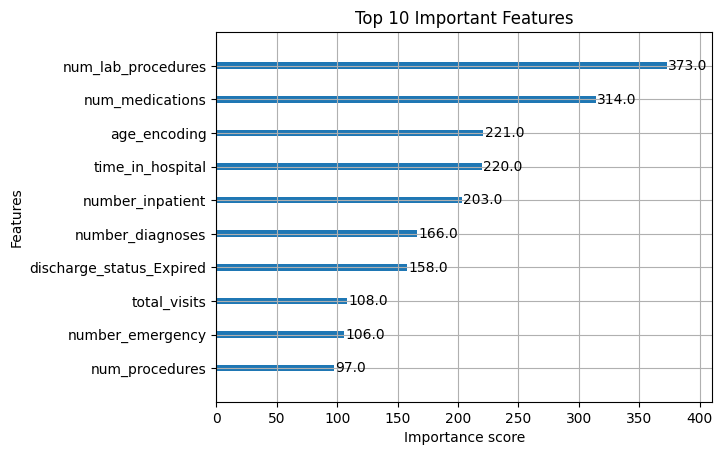

In [98]:
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Important Features")
plt.show()




In [101]:
import numpy as np
from sklearn.metrics import f1_score

y_proba = xgb_model.predict_proba(X_val)[:, 1]
thresholds = np.arange(0.2, 0.7, 0.01)
scores = [f1_score(y_val, y_proba >= t) for t in thresholds]

best_thresh = thresholds[np.argmax(scores)]
print("Best threshold:", best_thresh)
print("Best F1-score for Class 1:", max(scores))


Best threshold: 0.4400000000000002
Best F1-score for Class 1: 0.29030470914127426


In [103]:

from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[7088 1951]
 [ 611  524]]


In [108]:
from imblearn.over_sampling import SMOTE

In [111]:
# Split data first
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# We also need to encode the medication! 
meds = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone'
]

med_encoding = {'No':0,'Down':1,'Steady':2,'Up':3}
for col in meds:
    if col in X_train.columns:
        X_train[col] = X_train[col].map(med_encoding)
        X_val[col] = X_val[col].map(med_encoding)
        X_test[col] = X_test[col].map(med_encoding)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [122]:
import xgboost as xgb
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_resampled, y_resampled)

# Predict and evaluate
y_proba = model.predict_proba(X_val)[:, 1]

thresh = 0.18
y_pred_adj = (y_proba > thresh).astype(int)
print(classification_report(y_val, y_pred_adj))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:20:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.91      0.78      0.84     18079
           1       0.19      0.41      0.26      2270

    accuracy                           0.74     20349
   macro avg       0.55      0.59      0.55     20349
weighted avg       0.83      0.74      0.78     20349



In [123]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_index = f1_scores.argmax()

print(f"Best threshold: {thresholds[best_index]:.2f}")
print(f"F1-score at best threshold: {f1_scores[best_index]:.2f}")



Best threshold: 0.18
F1-score at best threshold: 0.26


In [ ]:
xgb_model = XGBClassifier(
    subsample= 0.9,
    n_estimators = 400,
    min_child_weight = 3,
    max_depth = 4,
    learning_rate = 0.05,
    colsample_bytree = 0.6,
    scale_pos_weight = 7,
    reg_alpha = 0.1,
    reg_lambda = 1.0,
    use_label_encoder = False,
    eval_metric = 'aucpr',
    random_state = 42
)
xgb_model.fit(X_train, y_train)
y_val_pred_xgb = xgb_model.predict(X_val)

print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))

y_proba = xgb_model.predict_proba(X_val)[:, 1]
thresh = 0.52
y_pred = (y_proba >= thresh).astype(int)
print("Classification Report:\n", classification_report(y_val, y_pred))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:13:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Validation Accuracy: 0.7090766131013809
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.78      0.84     18079
           1       0.21      0.46      0.29      2270

    accuracy                           0.74     20349
   macro avg       0.56      0.62      0.57     20349
weighted avg       0.84      0.74      0.78     20349



In [153]:
# I recommend weight 8.0 for the best balance
final_model = XGBClassifier(
    max_depth=4,
    min_child_weight=3,
    scale_pos_weight=8.0,
    subsample=0.9,
    n_estimators=400,
    learning_rate=0.05,
    colsample_bytree=0.6,
    eval_metric='logloss',
    random_state=42
)

final_model.fit(X_train, y_train)
y_proba_final = final_model.predict_proba(X_val)[:, 1]
y_pred_final = (y_proba_final >= 0.56).astype(int)

print("Final Optimized Model Results:")
print(classification_report(y_val, y_pred_final))

# Additional metrics
from sklearn.metrics import roc_auc_score, average_precision_score
auc_roc = roc_auc_score(y_val, y_proba_final)
auc_pr = average_precision_score(y_val, y_proba_final)
print(f"\nAUC-ROC: {auc_roc:.3f}")
print(f"AUC-PR: {auc_pr:.3f}")

Final Optimized Model Results:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     18079
           1       0.21      0.45      0.29      2270

    accuracy                           0.75     20349
   macro avg       0.57      0.62      0.57     20349
weighted avg       0.84      0.75      0.79     20349


AUC-ROC: 0.675
AUC-PR: 0.231


In [151]:
print("Final fine-tuning between 8.0 and 9.0:")
print("Weight | F1-Score | Precision | Recall | Best Threshold")
print("-" * 55)

# Test even more precise values
for weight in [8.0, 8.2, 8.4, 8.6, 8.8, 9.0]:
    model = XGBClassifier(
        max_depth=4,
        min_child_weight=3,
        scale_pos_weight=weight,
        subsample=0.9,
        n_estimators=400,
        learning_rate=0.05,
        colsample_bytree=0.6,
        eval_metric='logloss',
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # Find best threshold for this weight
    best_f1_weight = 0
    best_thresh_weight = 0.40
    best_precision = 0
    best_recall = 0
    
    for thresh in np.arange(0.45, 0.70, 0.01):  # Focused range based on your results
        y_pred = (y_prob >= thresh).astype(int)
        f1_1 = f1_score(y_val, y_pred)
        if f1_1 > best_f1_weight:
            best_f1_weight = f1_1
            best_thresh_weight = thresh
            best_precision = precision_score(y_val, y_pred)
            best_recall = recall_score(y_val, y_pred)
    
    print(f"{weight:4.1f}   | {best_f1_weight:.3f}    | {best_precision:.3f}     | {best_recall:.3f}  | {best_thresh_weight:.2f}")

Final fine-tuning between 8.0 and 9.0:
Weight | F1-Score | Precision | Recall | Best Threshold
-------------------------------------------------------
 8.0   | 0.289    | 0.213     | 0.448  | 0.56
 8.2   | 0.289    | 0.210     | 0.463  | 0.56
 8.4   | 0.289    | 0.212     | 0.451  | 0.57
 8.6   | 0.288    | 0.214     | 0.438  | 0.58
 8.8   | 0.287    | 0.210     | 0.451  | 0.58
 9.0   | 0.289    | 0.208     | 0.471  | 0.58
